# Model selection

We have barely scratched the surface of the big blob of available classification algorithms. There are many variations on kNN and decision trees, as well as algorithms we have not reached. And most learning algorithms have **hyperparameters** that control the complexity and theoretical resolving power of the algorithm. 

:::{note}
In ML, a *parameter* is a value that is adjusted during training; i.e., it is learned from the training data. A *hyperparameter* is one that is selected and remains fixed throughout the training. In most of mathematics, we would refer to these as *variables* and *parameters*, and sources aren't always fastidious about the latter term.
:::

With so many potential solutions available, we need to have a process for evaluating them.

## Overfitting

An obvious question about hyperparameters is: Why not just use maximum algorithm power all the time? It's not simply a matter of computing resource limitations, although that can be significant. 

Consider a kNN classifier with $k=1$. Each training sample's nearest neighbor is itself! So the classifier will perfectly fit the training data. Let's apply this to the loan application data, but using many different subsets of the training data in order to simulate what happens in parallel universes. We will use 1 minus accuracy as a measurement of error.

In [1]:
from sklearn import neighbors,metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import seaborn as sns

loans = pd.read_csv("loan_clean.csv")
X = loans.drop("percent_funded",axis=1)
y = loans["percent_funded"] > 95
X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.2)

n = 1000             # size of the training subset
err,kind = [],[]     # track information for the results
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
for i in range(200):
    X_tr,y_tr = shuffle(X_tr,y_tr,random_state=1)
    XX,yy = X_tr[:n,:],y_tr[:n]
    knn.fit(XX,yy) 
    err.append(1-knn.score(XX,yy))       # training error
    err.append(1-knn.score(X_te,y_te))   # test error
    kind.extend(["train","test"])

result = pd.DataFrame({"error":err,"kind":kind})
sns.displot(data=result,x="error",hue="kind",bins=24);

TypeError: '(slice(None, 1000, None), slice(None, None, None))' is an invalid key

As promised, the training error (blue histogram) is always zero. But the training error (orange histogram) tells a very different story. 

This is an illustration of **overfitting**. The classifier has perfectly replicated the training data, but it's unable to generalize to new data, which is what causes the wide gap between training and test. There is another effect, too: because the fit is highly tailored to the training set, the results depend strongly on the contents of that set, and there is a large amount of variance in the testing error. 

If we increase $k$ in the kNN classifier, then each prediction will look at more than one value in the training set, reducing the tendency to overfit to any local idiosyncrasies.

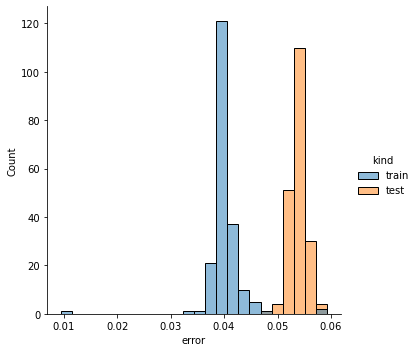

In [2]:
err,kind = [],[]     # track information for the results
knn = neighbors.KNeighborsClassifier(n_neighbors=6)
for i in range(200):
    X_tr,y_tr = shuffle(X_tr,y_tr,random_state=1)
    XX,yy = X_tr.loc[:n,:],y_tr.loc[:n]
    knn.fit(XX,yy) 
    err.append(1-knn.score(XX,yy))       # training error
    err.append(1-knn.score(X_te,y_te))   # test error
    kind.extend(["train","test"])

result = pd.DataFrame({"error":err,"kind":kind})
sns.displot(data=result,x="error",hue="kind",bins=24);

Now the training error is more comparable to the testing error, and the variance in the testing error is much smaller than before. 

## Bias–variance tradeoff

Suppose that $f(x)$ is a function giving the ground truth over the entire population. Let $\hat{f}(x)$ denote a learning algorithm obtained after training. Conceptually, $\hat{f}$ is just one realization that we get from one particular training set. We use $E[\cdot]$ to denote the process of averaging over all possible training sets. Note that the average of a sum of quantities is the sum of the averages.

Hence, the mean error is

$$
E\bigl[ f(x) - \hat{f}(x) \bigr] = f(x) - E\bigl[ \hat{f}(x) \bigr] = y - \hat{y},
$$

where $y=f(x)$ and $\hat{y}$ is the average prediction. This quantity is called the **bias**. 

Now we look at mean squared error:

$$
E\bigl[ (f(x) - \hat{f}(x))^2 \bigr] &= E\bigl[ (f(x) - \hat{y} + \hat{y} - \hat{f}(x))^2 \bigr] \\ 
&= E\bigl[ (f(x) - \hat{y})^2 \bigr] + E\bigl[ (\hat{y} - \hat{f}(x))^2 \bigr] - 2E\bigl[ (f(x) - \hat{y})(\hat{y} - \hat{f}(x)) \bigr] \\ 
&= (f(x) - \hat{y})^2 + E\bigl[ (\hat{y} - \hat{f}(x))^2 \bigr] - 2(f(x) - \hat{y}) E\bigl[ \hat{y} - \hat{f}(x) \bigr] \\
&= (f(x) - \hat{y})^2 + E\bigl[ (\hat{y} - \hat{f}(x))^2 \bigr].
$$

The first term is the squared bias. The second is the **variance** of the learning method. In words,

* Bias: How close is the average prediction to the ground truth? 
* Variance: How close to the average prediction is any one prediction likely to be?

There is a crude analogy with hitting the bullseye on a dartboard. A low-variance, high-bias learner will throw a tight cluster of darts far from the bullseye. A low-bias, high-variance learner will scatter the darts evenly all over the board. When learners are overfitted, their output on a test set depends sensitively on the choice of training set, which creates a large variance.

When a hyperparameter adjusts the number of degrees of freedom available to use for fitting, there might be decreased bias, simply because there is a larger universe of potential classifiers to choose from. But if taken too far, this approach tends to increase variance, because the higher fidelity is actually used to fit more closely to the particular training set that is chosen. This dilemma is generally known as the **bias–variance tradeoff**. This observation leads to an application of **Occam's Razor**: given methods with equal empirical error, choose the least complex one.

## Learning curves

We can illustrate the presence of bias and variance by repeated the parallel-universe experiment with different sizes for the training data sets. In order to have more data to pull from, we will use a subset of a realistic data set used to predict the dominant type of tree in patches of forest. We use a decision tree with fixed depth throughout.

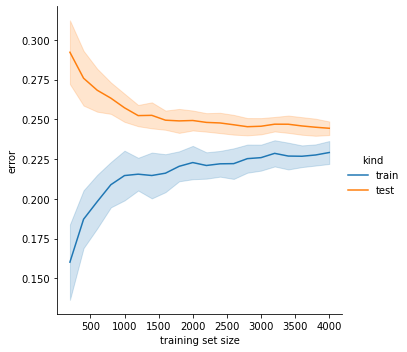

In [3]:
from sklearn import tree
from sklearn import datasets

forest = datasets.fetch_covtype()
X = forest["data"][:250000,:8]
y = forest["target"][:250000]
X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.05,shuffle=True,random_state=0)

N = range(200,4001,200)             # size of the training subset
err,kind,length = [],[],[]
dt = tree.DecisionTreeClassifier(max_depth=4) 
for n in N:
    for i in range(50):
        X_tr,y_tr = shuffle(X_tr,y_tr,random_state=1)
        XX,yy = X_tr[:n,:],y_tr[:n]
        dt.fit(XX,yy)
        err.append(1-dt.score(XX,yy))
        err.append(1-dt.score(X_te,y_te))
        kind.extend(["train","test"])
        length.extend([n,n])

result = pd.DataFrame({"error":err,"kind":kind,"training set size":length})
sns.relplot(data=result,x="training set size",y="error",kind="line",ci="sd",hue="kind");

The plot above shows **learning curves**. The dark line is the mean result over all trials, and the ribbon has a width of one standard deviation. For a small training set, the tree has more than enough resolving power, and we see a great deal of variance in the test error as well as a wide gap between those and the training errors. As the size of the training set grows, the two measurements come together as the variance decreases. The curves start to approach a horizontal asymptote that indicates the bias for this learner on this data set. 

## Cross-validation

Varying the training set offers a way to pick optimal hyperparameter values, or to compare different learners. However, if we base hyperparameter optimization on a fixed test set, then we are effectively learning from that set! That is, the hyperparameters might become too tuned to our particular choice of the test set, creating overfitting and variance. 

To avoid this situation, we can use **cross-validation**, in which each learner is trained multiple times, using both different training sets and different measurement sets. One popular version is **$k$-fold cross-validation**:

1. Divide the data into training and testing sets. 
2. Further divide the training data set into $k$ roughly equal parts called *folds*. 
3. Train the learner using folds $2,3,\ldots,k$ and validate (measure) on the cases in fold 1. Then retrain using folds $1,3,\ldots,k$ and validate against the cases in fold 2. Continue until each fold has served once for validation. 
4. Select the optimum hyperparameters and retrain on the entire training set.
5. Assess performance using the test set.  

For example, a round of 6-fold cross-validation on a standardized 5NN classifier looks like the following.

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate,KFold

X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.05)

kf = KFold(n_splits=6,shuffle=True,random_state=0)
knn = neighbors.KNeighborsClassifier(n_neighbors=5)
pipe = make_pipeline(StandardScaler(),knn)
scores = cross_validate(pipe,X_tr,y_tr,cv=kf,scoring="balanced_accuracy")

print(scores["test_score"])

[0.74474474 0.74132437 0.73814402 0.73257658 0.74011068 0.73680555]


The low variance across the folds is reassurance that they are representative subsets. Typically one would use the mean of these individual fold scores as the final metric. 

To wrap up, we will use cross-validation to perform an experiment complementary to the learning curve, sometimes called a **validation curve**. Here we hold the training set size constant while varying the depth of the tree.

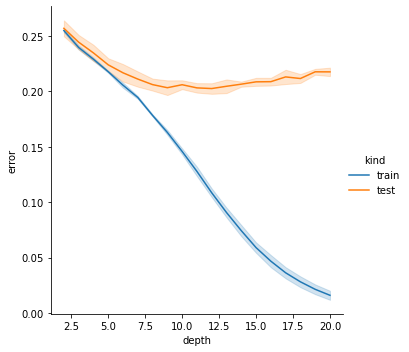

In [5]:
n = 20000             # size of the training subset
X_tr,y_tr = X_tr[:n,:],y_tr[:n]
depth = range(2,21,1)
kf = KFold(n_splits=6,shuffle=True,random_state=0)
d_all,err,kind = [],[],[]  # for keeping results
for d in depth:
    dt = tree.DecisionTreeClassifier(max_depth=d)
    cv = cross_validate(dt,X_tr,y_tr,cv=kf,return_train_score=True)

    # record training errors
    d_all.extend([d]*kf.n_splits)
    kind.extend(["train"]*kf.n_splits)
    err.extend(1-cv["train_score"])

    # record test errors
    d_all.extend([d]*kf.n_splits)
    kind.extend(["test"]*kf.n_splits)
    err.extend(1-cv["test_score"])

result = pd.DataFrame( {"depth":d_all,"error":err,"kind":kind} )
sns.relplot(data=result,x="depth",y="error",kind="line",ci="sd",hue="kind");

A decision tree gets more resolving power as its depth increases, so it is no surprise that the training error decreases monotonically. However, while the test error initially decreases too, eventually it hits a minimum and starts to increase. Past this point, the additional power being given to the trees is used only for overfitting; it's like shifting us back to the left end of the learning curve, where there is insufficient data to fully satisfy the model. Based on the validation curves, it would make sense to set the maximum depth to 11 for training a model that we want to use.